We have all the ingredients to create a differential equation. We now need the Julia side.

Our notation:

**Tensorflow side**
- `z__l_i`: (notice the 2 underspaces before `l` and 1 before `i`) element `i` of layer `l`
- `w__l_i_j`: weight for input `j` in layer `l-1` into `z__l_i`
- `b__l_i`: bias term for `z__l_i`

**ODE side**
- `z__l_i`: (notice the 2 underspaces before `l` and 1 before `i`) element `i` of layer `l`
- `k__l_i`: negative of `b__l_i`
- `a__l_i`: activating template for `z__l_i`
- `p__l_i`: pseudotemplate for `z__l_i`
- `lambda__l_i_j`: weight for positive input `j` in layer `l-1` into `z__l_i`, given by equation below
- `mu__l_i_j`: weight for negative input `j` in layer `l-1` into `z__l_i`, given by equation below

Differential equations: `__l` becomes a $\cdot^{[l]}$ and `_` becomes a subscript:

$$\frac{dz_i^{[l]}}{dt} = \epsilon + \frac{U a_i^{[l]}z_i^{[l]}}{k_i^{[l]} + z_i^{[l]}} - \frac{V p_i^{[l]}z_i^{[l]}}{k_i^{[l]} + z_i^{[l]}} - \alpha_i^{[l]}z_i^{[l]}$$

$$\frac{da_i^{[l]}}{dt} = \sum_j \lambda_{ij}^{[l]} x_j^{[l-1]} - \beta a_i^{[l]}$$
$$\frac{dp_i^{[l]}}{dt} = \sum_j \mu_{ij}^{[l]} x_j^{[l-1]} - \gamma p_i^{[l]}$$

where $\alpha_i^{[l]} = f(k_i^{[l]})$ for a fixed constant $f$, and
$$\lambda_{ij}^{[l]} = \frac{\beta \alpha_{i}^{[l]}}{U} w_{ij}^{[l]} \mathbb{1}_{w_{ij}^{[l]} > 0}$$
$$\mu_{ij}^{[l]} = -\frac{\gamma \alpha_{i}^{[l]}}{V} w_{ij}^{[l]} \mathbb{1}_{w_{ij}^{[l]} < 0}$$

In [15]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# import julia as jl
# # jl.install(julia="C:/Users/takes/AppData/Local/Programs/Julia 1.5.2/bin/julia.exe")
# from julia import DifferentialEquations
# from julia import Main
# DifferentialEquations.ODEProblem()

In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# model_folder = 'gdrive/My Drive/Research/Shared with Anthony/Deep Molecular Programming/job_035''

In [76]:
model_folder = '../../job_035'

In [77]:
model = tf.keras.models.load_model(os.path.join(model_folder, 'model'))

In [78]:
# https://leimao.github.io/blog/Dropout-Explained/
# Dropout in Tensorflow works a bit different from original implementation

In [79]:
ALPHA = 1.0
BETA = 1.0
GAMMA = 1.0
U = 1.0
V = 1.0
EPS = 1e-4
EPS2 = 1e-7

LOG_THRESH = 6
THRESH = 10**(-LOG_THRESH)

In [80]:
def force_round(n, p: int):
    assert p >= 0
    return round(10**p * n)/10**p

In [81]:
# Build W[l,i,j] and k[l,i]
def build_weight_and_bias_dictionaries(model):

    dense_layers = [layer for layer in model.layers if 'dense_' in layer.name]
    W_dict, b_dict = {}, {}
    for ll, layer in enumerate(dense_layers):
        L = ll+1

        w, b = layer.weights
        assert 'kernel:' in w.name
        assert 'bias:' in b.name
        wt, b = w.numpy().T, b.numpy()

        len_wt, len_this_layer = len(wt), len(b)
        assert len_wt == len_this_layer

        for i in range(len_this_layer):
            len_prev_layer = len(wt[0])
            b_dict[(L,i)] = b[i]
            W_dict[(L,i)] = {}
            for j in range(len_prev_layer):
                W_dict[(L,i)][j] = wt[i][j]

    return W_dict, b_dict        

def build_degradation_constants(b):
    # very simple model..
    alpha = {key: ALPHA for key in b.keys()}
    return alpha
        
def build_positive_and_negative_chemical_weights(W, alpha_dict, beta, gamma, U, V, log_thresh=LOG_THRESH):
    
    def w_to_lambda(w, l_i_j):
        l, i, _ = l_i_j
        alpha = alpha_dict[(l,i)]
        return beta * alpha * w / U

    def w_to_mu(w, l_i_j):
        l, i, _ = l_i_j
        alpha = alpha_dict[(l,i)]
        return - gamma * alpha * w / V
    
    used_weights, non_used_weights = 0, 0
    lambda_dict, mu_dict = {}, {}
    for l_i, subdict in W.items():
        lambda_dict[l_i] = {}
        mu_dict[l_i] = {}
        for j, w_ij in subdict.items():
            if w_ij > 10**(-log_thresh):
                used_weights += 1
                lambda_dict[l_i][j] = force_round(beta * alpha[l_i] * w_ij / U, log_thresh)
            elif w_ij < -10**(-log_thresh):
                used_weights += 1
                mu_dict[l_i][j] = - force_round(gamma * alpha[l_i] * w_ij / V, log_thresh)
            else:
                non_used_weights += 1
    
    total_weights = used_weights + non_used_weights
    print(f"  > Used {used_weights} out of {total_weights} weights with a threshold of 10^{-log_thresh}")
    
    return lambda_dict, mu_dict

In [82]:
W, b = build_weight_and_bias_dictionaries(model)
alpha = build_degradation_constants(b)

In [83]:
lambda_dict, mu_dict = build_positive_and_negative_chemical_weights(W, alpha, BETA, GAMMA, U, V, log_thresh=6)

  > Used 1972 out of 2240 weights with a threshold of 10^-6


We have all the ingredients to create a differential equation:

* Given $(l,i)$ we can immediately write the 3 equations for `z__l_i, a__l_i` and `p__l_i`

In [84]:
def _var(name, l, i):
    return f"{name}__{l}_{i}_"

def _dvar(name, l, i):
    return "d" + _var(name, l, i) 

def _dvar_to_var(dvar):
    return dvar[1:]

def hidden_layer_list(W):
    return list(set([key[0] for key in W.keys()]))

def last_layer(W):
    return hidden_layer_list(W)[-1]

def nodes_in_layer(W, l):
    assert l != 0, 'Initial layer not accessible from this method'
    ll = l if l > 0 else hidden_layer_list(W)[-1]
    return [key[1] for key in W.keys() if key[0] == ll]

In [218]:
def write_z_ode(b_dict, alpha_dict, l, i, log_thresh=LOG_THRESH):
    
    var_list, dvar_list = [], []
    
    z = _var('z', l, i)
    a = _var('a', l, i)
    p = _var('p', l, i)
    
    dz = _dvar('z', l, i)

    kM = -force_round(b_dict[(l,i)], log_thresh)
    alpha = alpha_dict[(l,i)]
    
    dz_ode = f"{dz} = ({EPS2} + ({U} * {a} - {V} * {p}) * {z}/({kM} + {z} + {EPS}) - {alpha} * {z})"  
    
    # also return which variables and dvariables we have
    var_list.extend([z, a, p])
    dvar_list.append(dz)
    
    return dz_ode, var_list, dvar_list

def write_aT_pT_odes(lambda_dict, mu_dict, alpha_dict, l, i):
    
    lambda_subdict, mu_subdict= lambda_dict[(l,i)], mu_dict[(l,i)]
    
    var_list, dvar_list = [], []

    a = _var('a', l, i)
    p = _var('p', l, i)
    da = _dvar('a', l, i)
    dp = _dvar('p', l, i)
    
    var_list.extend([a, p])
    dvar_list.extend([da, dp])

    # ODE for da/dt
    positive_weight_expr_list = []
    for j, lamb in lambda_subdict.items():
        new_z = _var('z', l-1, j)
        var_list.append(new_z)
        positive_weight_expr_list.append(f"{lamb} * {new_z} ")
        
    da_ode = f"{da} = ({EPS2} +" + "\n            +".join(positive_weight_expr_list) + f"\n            - {BETA} * {a})"
    
    # ODE for dp/dt
    negative_weight_expr_list = []
    for j, mu in mu_subdict.items():
        new_z = _var('z', l-1, j)
        var_list.append(new_z)
        negative_weight_expr_list.append(f"{mu} * {new_z}")
        
    dp_ode = f"{dp} = ({EPS2} +"  + "\n            +".join(negative_weight_expr_list) + f"\n            - {GAMMA} * {p})"
    
    return da_ode, dp_ode, var_list, dvar_list

In [219]:
z_ode, var_list_1, dvar_list_1 = write_z_ode(b, alpha, 1,3, log_thresh=5)
print(z_ode)

dz__1_3_ = (1e-07 + (1.0 * a__1_3_ - 1.0 * p__1_3_) * z__1_3_/(0.21644 + z__1_3_ + 0.0001) - 1.0 * z__1_3_)


In [220]:
l = 1
var_list_ap = []
dvar_list_ap = []
for i in nodes_in_layer(W, l)[:2]:
    a_ode, p_ode, var_list, dvar_list = write_aT_pT_odes(lambda_dict, mu_dict, alpha, l, i)
    var_list_ap.extend(var_list)
    dvar_list_ap.extend(dvar_list)
    print(a_ode)
    print(p_ode)

da__1_0_ = (1e-07 +0.023053 * z__0_2_ 
            +0.009894 * z__0_6_ 
            +0.001159 * z__0_7_ 
            +0.024381 * z__0_9_ 
            +0.21541 * z__0_12_ 
            +0.048058 * z__0_15_ 
            +0.007887 * z__0_17_ 
            +0.011531 * z__0_18_ 
            +0.024447 * z__0_19_ 
            +0.00036 * z__0_20_ 
            +0.005142 * z__0_22_ 
            +0.111522 * z__0_23_ 
            +0.004735 * z__0_24_ 
            - 1.0 * a__1_0_)
dp__1_0_ = (1e-07 +4e-06 * z__0_0_
            +0.003178 * z__0_1_
            +0.014859 * z__0_3_
            +0.003226 * z__0_4_
            +0.031777 * z__0_5_
            +0.006073 * z__0_8_
            +0.015549 * z__0_10_
            +0.008069 * z__0_11_
            +0.00131 * z__0_13_
            +0.066586 * z__0_14_
            +0.002276 * z__0_16_
            +0.008999 * z__0_21_
            - 1.0 * p__1_0_)
da__1_1_ = (1e-07 +4.7e-05 * z__0_0_ 
            +0.000382 * z__0_4_ 
            +0.019254 * z__0_7_ 
    

## Putting into a format that makes sense for Julia

In [221]:
model = tf.keras.models.load_model(os.path.join(model_folder, 'model'))

In [222]:
def resize_images(X, pixel_size: int, plot=True, method='bilinear'):
    """
    Reshapes MNIST images into [pixel_size, pixel_size] images.
    This supposes we only have 1 channel
    """
    num_imgs, width, length = X.shape
    X_new = X.reshape(num_imgs, width, length, 1)
    X_new = tf.image.resize(X_new, (pixel_size, pixel_size), method=method).numpy()
    X_new = X_new.reshape(num_imgs, pixel_size, pixel_size)

    # Plot
    if plot:
        figs_to_plot = min(5, num_imgs)
        fig, ax = plt.subplots(figsize=(5, 1 * figs_to_plot), nrows=figs_to_plot, ncols=2)
        for i in range(figs_to_plot):
            ax[i][0].imshow(X[i, :, :])
            ax[i][1].imshow(X_new[i, :, :])
        plt.tight_layout()
        plt.show()

    return X_new

def preprocess_mnist_data_training(X, y):
    """
    Normalize inputs and reshape into 1d vector.
    Exports normalizing parameters from training set, and will provide this to test set
    """
    max_X = np.max(X.flatten())
    min_X = np.min(X.flatten())

    new_X = ((X - min_X) / (max_X - min_X)).reshape(X.shape[0], X.shape[1] * X.shape[2])
    new_y = y

    return new_X, new_y, max_X, min_X


def preprocess_mnist_data_test(X, y, max_X, min_X):
    """
    Normalize inputs and reshape into 1d vector
    """
    new_X = ((X - min_X) / (max_X - min_X)).reshape(X.shape[0], X.shape[1] * X.shape[2])
    new_y = y
    return new_X, new_y

def preprocess_mnist_full(X_train_raw, X_test_raw, y_train_raw, y_test_raw, pixel_new_width):
    assert pixel_new_width in range(1, 29), 'Invalid new width'

    X_train = resize_images(X_train_raw, pixel_size=pixel_new_width, plot=False)
    X_test = resize_images(X_test_raw, pixel_size=pixel_new_width, plot=False)

    # subsampled
    X_train, y_train, max_X, min_X = preprocess_mnist_data_training(X_train, y_train_raw)
    X_test, y_test = preprocess_mnist_data_test(X_test, y_test_raw, max_X, min_X)

    return X_train, X_test, y_train, y_test

In [223]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test,  y_train, y_test = preprocess_mnist_full(X_train, X_test, y_train, y_test, pixel_new_width=5)

In [224]:
W, b = build_weight_and_bias_dictionaries(model)
alpha = build_degradation_constants(b)
lambda_dict, mu_dict = build_positive_and_negative_chemical_weights(W, alpha, BETA, GAMMA, U, V)

  > Used 1972 out of 2240 weights with a threshold of 10^-6


In [225]:
def add_tabs(string, nspaces):
    return " "*(nspaces*4) + string

In [226]:
def build_ode_string(W, b, alpha, lambda_dict, mu_dict):
    layer_list = hidden_layer_list(W)
    print(f"Creating script for network with {len(layer_list)} hidden layer(s)")
    
    ode_list, var_list, dvar_list = [], [], []
    for l in layer_list:
        for i in nodes_in_layer(W, l):
            # Calculate ODE for z (add 4 spaces afterwards)
            z_ode, var_list_1, dvar_list_1 = write_z_ode(b, alpha, l, i)
            z_ode = add_tabs(z_ode, 1)
            
            # Calculate ODE for aT, pT (add 4 spaces afterwards)
            a_ode, p_ode, var_list_2, dvar_list_2 = write_aT_pT_odes(lambda_dict, mu_dict, alpha, l, i)
            a_ode = add_tabs(a_ode, 1)
            p_ode = add_tabs(p_ode, 1)
            
            # Add equations to list of equations, and add variables to list of variables
            var_list.extend(var_list_1 + var_list_2)
            dvar_list.extend(dvar_list_1 + dvar_list_2)
            ode_list.extend([z_ode, a_ode, p_ode])
    
    # Keep track of a dictionary mapping each variable to a number, eg. z_4__23: 2
    # this is important because we will input everything in Julia as x[2] so we need
    # to convert the result back to Python afterwards
    enumerated_variables_dict = {var: num+1 for num, var in enumerate(set(var_list))}
    var_to_julia_ode_var_dict = {var: f"x[{n}]" for var, n in enumerated_variables_dict.items()}
    
    full_ode_string = '\n'.join(ode_list)
    for key, val in var_to_julia_ode_var_dict.items():
        full_ode_string = full_ode_string.replace(key, val)
    
    return full_ode_string, enumerated_variables_dict

In [227]:
full_ode_string, enumerated_variables_dict = build_ode_string(W, b, alpha, lambda_dict, mu_dict)

Creating script for network with 2 hidden layer(s)


In [228]:
def build_initial_conditions(enumerated_variables_dict, X):
    # X is a flattened version of inputs, scaled to 0-1
    from collections import OrderedDict
    
    z_dict_X = {_var('z', 0, i): x for i, x in enumerate(X)}
    
    initial_conditions_dict = {}
    for var, n in enumerated_variables_dict.items():
        if 'z__0' in var:
            initial_conditions_dict[n] = max(z_dict_X[var], EPS)
        else:
            initial_conditions_dict[n] = EPS*np.random.uniform()
    
    ordered_initial_conditions = OrderedDict(sorted(initial_conditions_dict.items()))
    return list(ordered_initial_conditions.values())

In [242]:
def create_julia_file_body(full_ode_string, initial_conditions, output_file, dt=0.01, tmax=1000.0):
    string = "using OrdinaryDiffEq\nusing DataFrames\nusing CSV"  # DifferentialEquations
    string+= "\n\nfunction f!(dx, x, p, t)\n"
    string+= full_ode_string
    string+= "\nend"
    string+= f"\nx0 = {initial_conditions}\ntspan = (0.0, {tmax})"
    string+= "\nprob=ODEProblem(f!,x0,tspan)"
    string+= f"\nsol=solve(prob, Euler(), isoutofdomain=(du,u,p,t) -> any(x -> x < 0, u); dt={dt})" #  Vern7(), reltol=1e-6, abstol=1e-4
    string+= "\ndf = DataFrame(sol)"
    string+= f"\nCSV.write(\"{output_file}\",df)"
    return string

In [243]:
k = 8
X_use = X_test[k]
print(y_test[k])
import matplotlib.pyplot as plt
plt.imshow(X_use.reshape(5,5))

5


ValueError: cannot reshape array of size 100 into shape (5,5)

In [129]:
initial_conditions = build_initial_conditions(enumerated_variables_dict, X_use)

In [130]:
output_test_file = "../test_output.csv"
julia_script_file = '_output.jl'
myfile_body = create_julia_file_body(full_ode_string, initial_conditions, output_test_file)
with open(julia_script_file, 'w') as f:
    f.write(myfile_body)

In [131]:
%%time
os.system(f"julia {julia_script_file}")
os.remove(julia_script_file)

Wall time: 4min 39s


Read output and find how the outputs varied

In [132]:
df = pd.read_csv(output_test_file)

In [244]:
def get_output_variables(W, enumerated_variables_dict):
    last_layer_l = last_layer(W)
    last_layer_nodes_i = nodes_in_layer(W,last_layer_l)

    output_var_names = [_var('z', last_layer_l, i) for i in last_layer_nodes_i]
    
    return list(set(output_var_names))#[enumerated_variables_dict[var] for var in set(output_var_names)]

In [134]:
df_out = df.loc[get_output_variables(W, enumerated_variables_dict)].T
df_out = df_out.rename({col: i for i, col in enumerate(df_out.columns)}, axis=1)
df_out.index = range(len(df_out))

<AxesSubplot:>

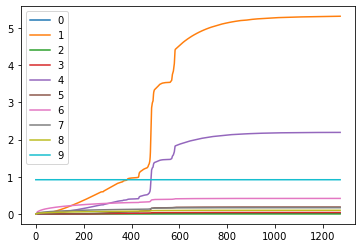

In [135]:
df_out.plot()

In [523]:
# Installing Julia wrapper: https://towardsdatascience.com/run-native-julia-code-with-python-92d3e1079385
# On Julia prompt:
# using Pkg; Pkg.add("PyCall")
# build "PyCall"
# On Anaconda (conda didnt work, used pip)
# pip3 install julia

In [245]:
class ODE_model:
    
    def __init__(self, model, log_threshold=LOG_THRESH):
        self.log_threshold = log_threshold
        self.tf_model = model
        self.W, self.b = build_weight_and_bias_dictionaries(model)
        self.alpha = build_degradation_constants(self.b)
        self.lambda_dict, self.mu_dict = build_positive_and_negative_chemical_weights(self.W, self.alpha, BETA, GAMMA, U, V, log_threshold)
        self.full_ode_string, self.enumerated_variables_dict = build_ode_string(self.W, self.b, self.alpha, self.lambda_dict, self.mu_dict)
    
    def get_z_variables(self, layer=-1):
        
        if layer == -1:
            layer = last_layer(self.W)
        
        nodes_i = nodes_in_layer(self.W, layer)

        return [_var('z', layer, i) for i in nodes_i]
    
    def get_aT_pT_variables(self, layer=-1):
        
        if layer == -1:
            layer = last_layer(self.W)
        
        nodes_i = nodes_in_layer(self.W, layer)

        return [_var('a', layer, i) for i in nodes_i] + [_var('p', layer, i) for i in nodes_i]
    
    def predict(self, X, dt=0.01, tmax=1000.0):
        initial_conditions = build_initial_conditions(self.enumerated_variables_dict, X)
        output_test_file = "../test_output.csv"
        if os.path.exists(output_test_file):
            os.remove(output_test_file)
        julia_script_file = '_output.jl'
        self.myfile_body = create_julia_file_body(self.full_ode_string, initial_conditions, output_test_file, dt=dt, tmax=tmax)
        with open(julia_script_file, 'w') as f:
            f.write(self.myfile_body)
        
        # run Julia file and delete it
        os.system(f"julia {julia_script_file}")
        os.remove(julia_script_file)
        
        # read output and process
#         df = pd.read_csv(output_test_file)
#         df_out = df.loc[get_output_variables(self.W, self.enumerated_variables_dict)].T
#         df_out = df_out.rename({col: i for i, col in enumerate(df_out.columns)}, axis=1)
#         df_out.index = range(len(df_out))
        
        df = pd.read_csv(output_test_file).\
            T.\
            rename({val-1: key for key, val in self.enumerated_variables_dict.items()}, axis=1)
        df.index = np.array(range(len(df)))*dt
    
        return df

In [246]:
# pruned_model = tf.keras.models.load_model(os.path.join('../../job_163/pruned_0.7', 'model')) # 

In [247]:
model = tf.keras.models.load_model(os.path.join('../../job_163', 'model')) # /pruned_0.7

In [248]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test,  y_train, y_test = preprocess_mnist_full(X_train, X_test, y_train, y_test, pixel_new_width=10)

In [249]:
ode_model = ODE_model(model, log_threshold=100)

  > Used 1760 out of 1760 weights with a threshold of 10^-100
Creating script for network with 2 hidden layer(s)


1


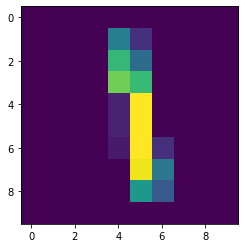

In [250]:
k = 6
X_use = X_train[k]
print(y_train[k])
import matplotlib.pyplot as plt
plt.imshow(X_use.reshape(10,10))
plt.show()

In [251]:
%%time
df = ode_model.predict(X_use, dt=0.01, tmax=30.0)

Wall time: 28.4 s


<AxesSubplot:>

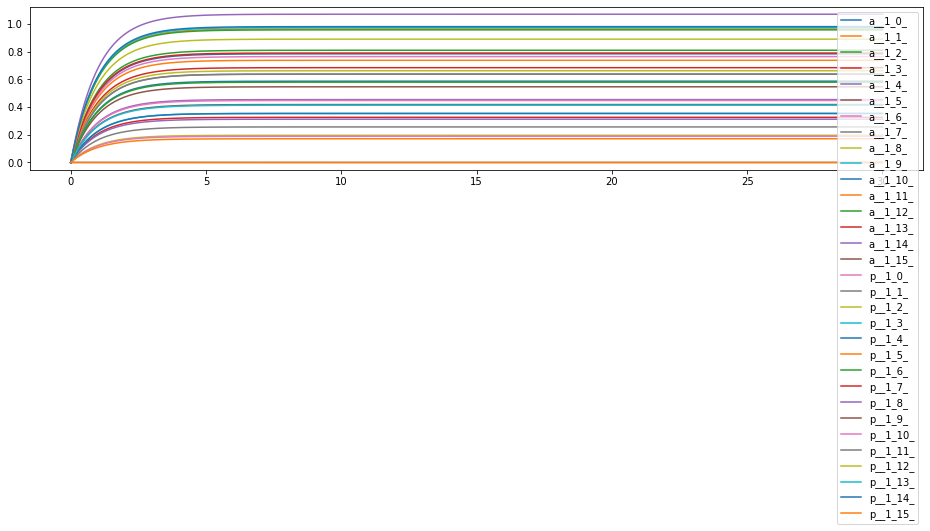

In [252]:
df[ode_model.get_aT_pT_variables(1)].plot(figsize=(16,3))

In [253]:
print(ode_model.myfile_body)

using OrdinaryDiffEq
using DataFrames
using CSV

function f!(dx, x, p, t)
    dx[26] = (1e-07 + (1.0 * x[77] - 1.0 * x[30]) * x[26]/(0.016968 + x[26] + 0.0001) - 1.0 * x[26])
    dx[77] = (1e-07 +3.6983219594578494e-34 * x[59] 
            +0.027159379795193672 * x[135] 
            +1.1398161348097345e-07 * x[46] 
            +1.7862832358904636e-33 * x[89] 
            +6.223103827451653e-34 * x[175] 
            +0.09548960626125336 * x[6] 
            +0.031379029154777534 * x[93] 
            +0.009839826263487339 * x[86] 
            +0.0381547175347805 * x[168] 
            +0.14628362655639648 * x[49] 
            +0.07514231652021408 * x[71] 
            +0.009458126500248909 * x[78] 
            +0.2700837552547455 * x[25] 
            +0.159094899892807 * x[42] 
            +0.024512115865945816 * x[58] 
            +0.037208933383226395 * x[120] 
            +0.005234589334577322 * x[1] 
            +0.2631492018699646 * x[158] 
            +0.19015713036060333 * x[51] 
   

<AxesSubplot:>

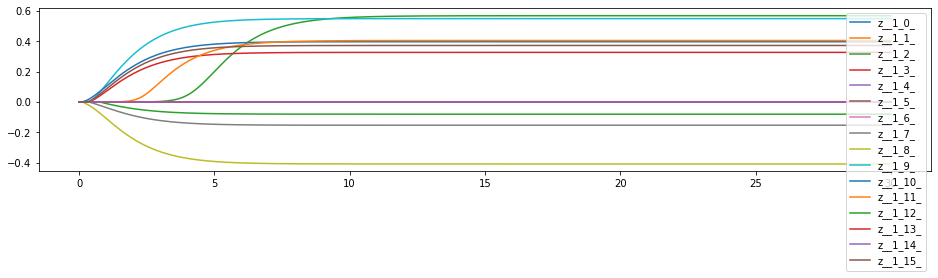

In [254]:
df[ode_model.get_z_variables(1)].plot(figsize=(16,3))

In [190]:
ode_model.enumerated_variables_dict['z__1_8_']

164

In [217]:
print(ode_model.full_ode_string)

    dx[26] = (1e-07 + (1.0 * x[77] - 1.0 * x[30]) * x[26]/(0.016968 + x[26] + 1e-07) - 1.0 * abs(x[26]))
    dx[77] = (1e-07 +3.6983219594578494e-34 * x[59] 
            +0.027159379795193672 * x[135] 
            +1.1398161348097345e-07 * x[46] 
            +1.7862832358904636e-33 * x[89] 
            +6.223103827451653e-34 * x[175] 
            +0.09548960626125336 * x[6] 
            +0.031379029154777534 * x[93] 
            +0.009839826263487339 * x[86] 
            +0.0381547175347805 * x[168] 
            +0.14628362655639648 * x[49] 
            +0.07514231652021408 * x[71] 
            +0.009458126500248909 * x[78] 
            +0.2700837552547455 * x[25] 
            +0.159094899892807 * x[42] 
            +0.024512115865945816 * x[58] 
            +0.037208933383226395 * x[120] 
            +0.005234589334577322 * x[1] 
            +0.2631492018699646 * x[158] 
            +0.19015713036060333 * x[51] 
            +0.22027352452278137 * x[28] 
            +0.4564467668533326

<AxesSubplot:>

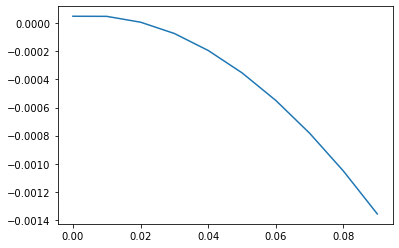

In [193]:
df['z__1_8_'].iloc[:10].plot()

<AxesSubplot:>

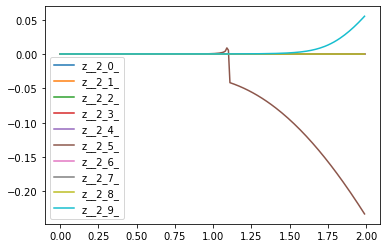

In [174]:
df[ode_model.get_z_variables(-1)].plot()

<AxesSubplot:>

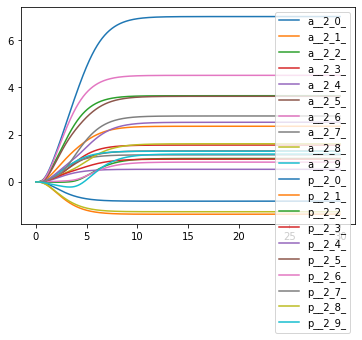

In [176]:
df[ode_model.get_aT_pT_variables(-1)].plot()

# Testing 

In [205]:
output_test_file = "mycsvfile.csv"
dt = 0.01

string = "using OrdinaryDiffEq\nusing DataFrames\nusing CSV\n" # using DiffEqIO
string+= "\n\nfunction f!(dx, x, p, t)"
string+= "\n    dx[2] = 0.0001 + 0.5 - x[2]"
string+= "\n    dx[3] = 0.0001 + 0.8 - x[3]"
string+= "\n    dx[1] = 0.0001 + (3.0* x[2] - 2.0 * x[3])*x[1]/(1.0 + x[1]) - x[1]"
string+= "\nend"
string+= f"\nx0 = [0.0001, 0.0001, 0.0001]\ntspan = (0.0,20.0)"
string+= "\nprob=ODEProblem(f!,x0,tspan)"
string+= f"\nsol=solve(prob, Euler(), isoutofdomain=(u,p,t) -> any(x -> x < 0, u); dt={dt})" #  Vern7(), reltol=1e-6, abstol=1e-4
string+= "\ndf = DataFrame(sol)"
string+= f"\nCSV.write(\"{output_test_file}\",df)\n"


if os.path.exists(output_test_file):
    os.remove(output_test_file)

julia_script_file = '_output.jl'
with open(julia_script_file, 'w') as f:
    f.write(string)

os.system(f"julia {julia_script_file}")
print(out)
print(f"Closed {julia_script_file}")
os.remove(julia_script_file)

df = pd.read_csv(output_test_file).T
df.index = np.array(range(len(df)))*dt
df.rename({0: 'z', 1: 'aT', 2: 'pT'}, axis=1, inplace=True)

1
Closed _output.jl


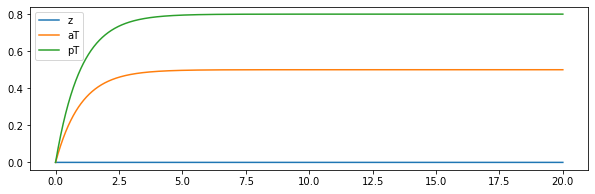

In [206]:
df.plot(figsize=(10,3)); plt.show()

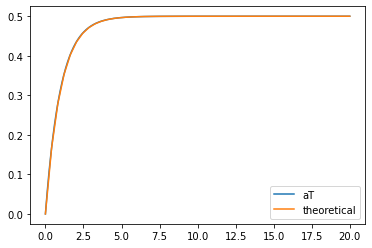

In [64]:
fig, ax = plt.subplots()
df[['aT']].plot(ax=ax, label='ode')
x = np.linspace(0,20)
y = 0.0001 + 0.5*(1-np.exp(-x))
ax.plot(x,y, label='theoretical')
plt.legend()

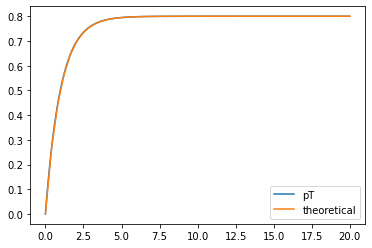

In [65]:
fig, ax = plt.subplots()
df[['pT']].plot(ax=ax, label='ode')
x = np.linspace(0,20)
y = 0.0001 + 0.8*(1-np.exp(-x))
ax.plot(x,y, label='theoretical')
plt.legend()